In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

/var/folders/v9/wq9d9w3501v5y6219s4smvyw0000gn/T/ipykernel_40861/3707268433.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Define Dataset

In [2]:
from torch.utils.data import Dataset, DataLoader

class RNA2D_Dataset(Dataset):
    def __init__(self,data):
        self.data=data
        self.tokens={nt:i for i,nt in enumerate('ACGU')}

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sequence=[self.tokens[nt] for nt in self.data.loc[idx,'sequence']]
        sequence=np.array(sequence)
        sequence=torch.tensor(sequence)

        return {'sequence':sequence}

In [3]:
test_data=pd.read_json("/Users/lihongmin/Research/24 mRNAdegredation/RNAdegformer/src/OpenVaccine/data/test.json",lines=True)
test_dataset=RNA2D_Dataset(test_data)
test_dataset[0]

{'sequence': tensor([2, 2, 0, 0, 0, 0, 2, 3, 0, 1, 2, 0, 1, 3, 3, 2, 0, 2, 3, 0, 1, 2, 2, 0,
         0, 0, 0, 1, 2, 3, 0, 1, 1, 0, 0, 1, 3, 1, 2, 0, 3, 3, 0, 0, 0, 0, 3, 2,
         2, 3, 1, 0, 0, 0, 2, 0, 2, 2, 3, 1, 2, 0, 0, 0, 3, 0, 1, 0, 2, 0, 3, 2,
         0, 1, 1, 3, 3, 1, 2, 2, 2, 3, 3, 0, 3, 1, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0,
         0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1])}

In [4]:
len(test_data)

3634

# Define Model

In [5]:


from Network import *
import yaml

class Config:
    def __init__(self, **entries):
        self.__dict__.update(entries)
        self.entries=entries

    def print(self):
        print(self.entries)

def load_config_from_yaml(file_path):
    with open(file_path, 'r') as file:
        config = yaml.safe_load(file)
    return Config(**config)

class finetuned_RibonanzaNet(RibonanzaNet):
    def __init__(self, config):
        super(finetuned_RibonanzaNet, self).__init__(config)

        self.decoder = nn.Linear(config.ninp,5)
        
    def forward(self,src):
        
        sequence_features, pairwise_features=self.get_embeddings(src, torch.ones_like(src).long().to(src.device))

        output=self.decoder(sequence_features) #predict

        return output#.squeeze(-1)

In [7]:
config=load_config_from_yaml("configs/pairwise.yaml")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device= torch.device("mps")
model=finetuned_RibonanzaNet(config).to(device)
#1. Initial Model Training-only confident labels:
model.load_state_dict(torch.load("../ribonanzanet-weights/RibonanzaNet-Deg31.pt",map_location=device))

constructing 9 ConvTransformerEncoderLayers


<All keys matched successfully>

# Make predictions

In [9]:
from tqdm import tqdm

test_preds=[]
model.eval()
for i in tqdm(range(len(test_dataset))):
    example=test_dataset[i]
    sequence=example['sequence'].to(device).unsqueeze(0)

    with torch.no_grad():
        test_preds.append(model(sequence).cpu().numpy())

  0%|          | 0/3634 [00:00<?, ?it/s]/Users/lihongmin/mambaforge/envs/torch/lib/python3.9/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/lihongmin/mambaforge/envs/torch/lib/python3.9/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
  4%|▍         | 149/3634 [00:13<05:10, 11.24it/s]


KeyboardInterrupt: 

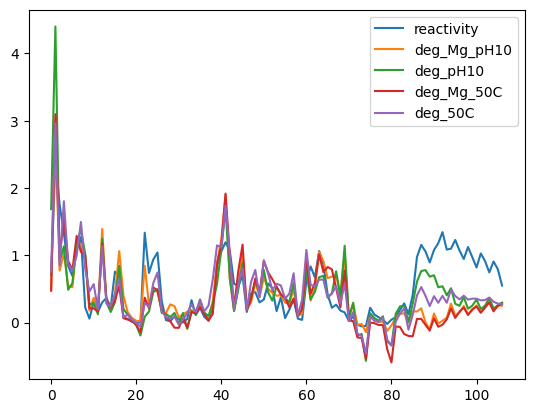

In [10]:
# let's take a look at the predictions
import matplotlib.pyplot as plt
labels=['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
for i in range(5):
    
    plt.plot(test_preds[0][0,:,i],label=labels[i])
    
plt.legend()


In [11]:
preds=[]
ids=[]
for i in range(len(test_data)):
    preds.append(test_preds[i][0,:])
    id=test_data.loc[i,'id']
    ids.extend([f"{id}_{pos}" for pos in range(len(test_preds[i][0,:]))])
    #break
preds=np.concatenate(preds)
preds.shape

IndexError: list index out of range

In [13]:
sub=pd.DataFrame()

sub['id_seqpos']=ids

for i,l in enumerate(['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']):
    sub[l]=preds[:,i]
sub.to_csv('submission.csv',index=False)